In [1]:
#Imports
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from scipy import stats
from sklearn.preprocessing import StandardScaler


In [2]:
df = pd.read_csv('datasets/vinho/winequality-red.csv', delimiter=";")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
df.shape

(1599, 12)

In [4]:
df["quality"].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

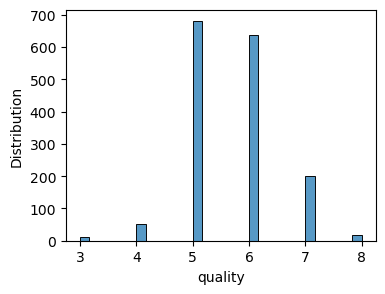

In [5]:
plt.figure(figsize=(4,3))
sns.histplot(df["quality"])
plt.xlabel("quality")
plt.ylabel("Distribution")
plt.show()

In [6]:
#Função para calcular pvalor
def calculate_pvalues(df):
    df_cols = pd.DataFrame(columns=df.columns)
    pvalues = df_cols.transpose().join(df_cols, how='outer')
    
    for r in df.columns:
        for c in df.columns:
            if r != c:
                if df[r].nunique() > 1 and df[c].nunique() > 1:  # Verifica se ambas as colunas têm mais de um valor único
                    pvalue = round(pearsonr(df[r], df[c])[1], 4)
                    if pvalue < 0.01:
                        pvalues[r][c] = '< 0.01'
                    else:
                        pvalues[r][c] = pvalue
                else:
                    pvalues[r][c] = np.nan  # Coloca NaN se uma das colunas for constante
            else:
                pvalues[r][c] = np.nan  # Coloca NaN na diagonal principal

    return pvalues

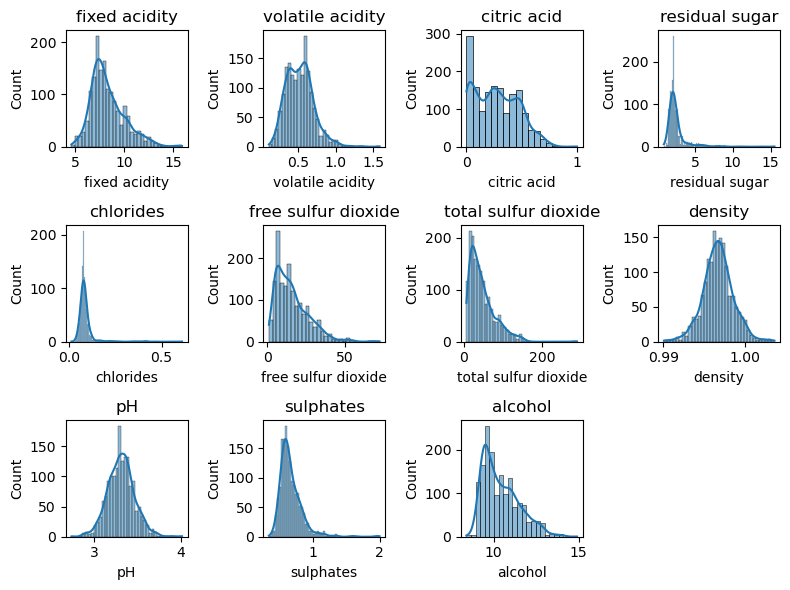

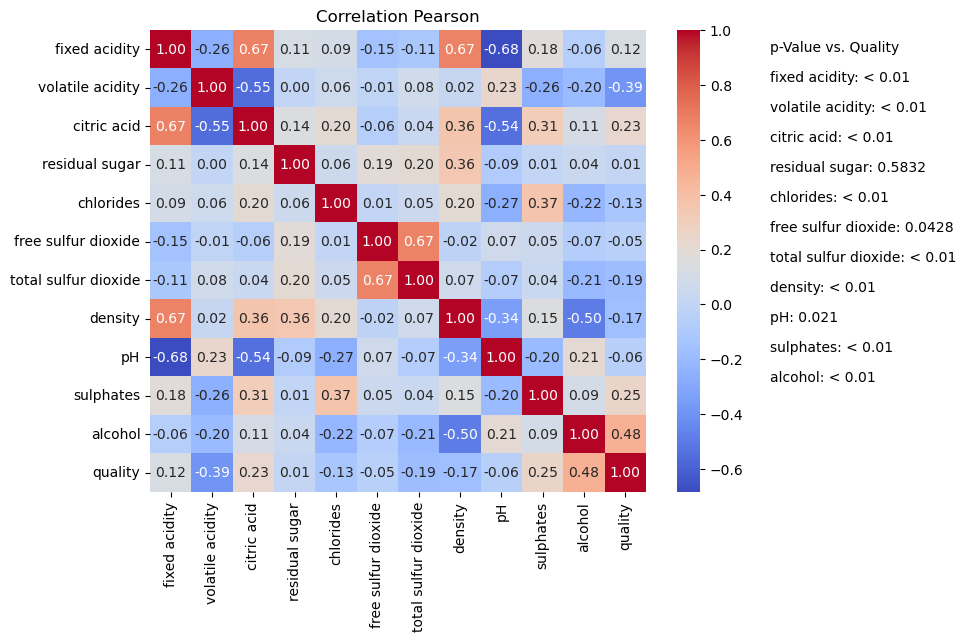

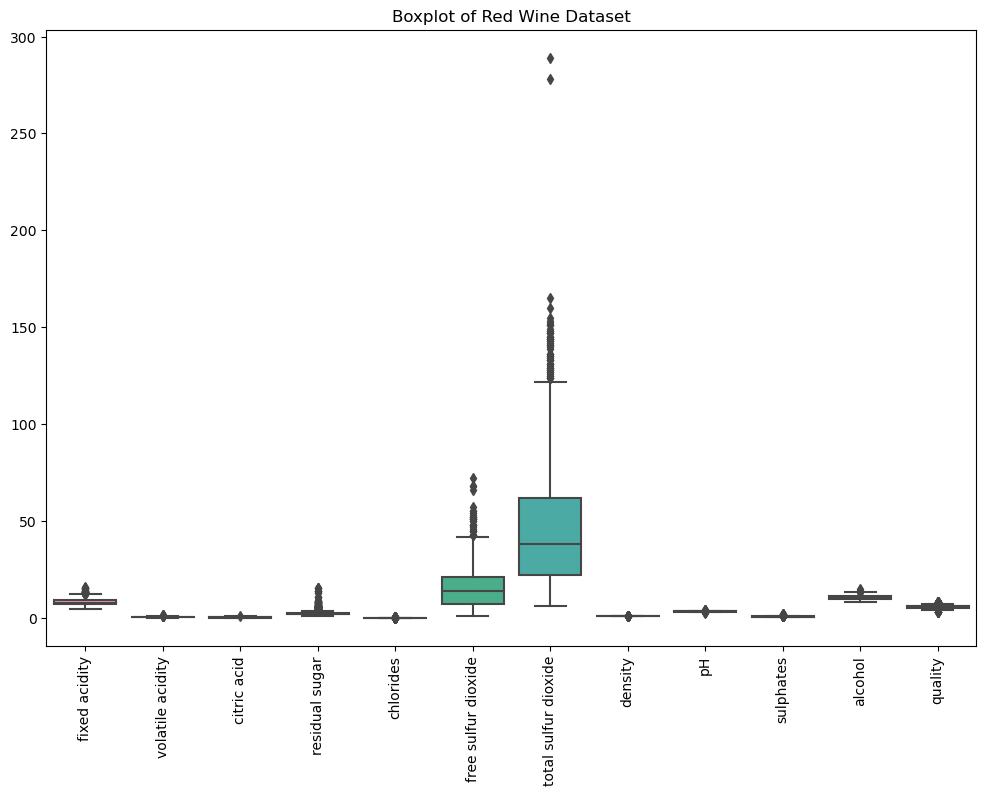

<Figure size 1200x800 with 0 Axes>

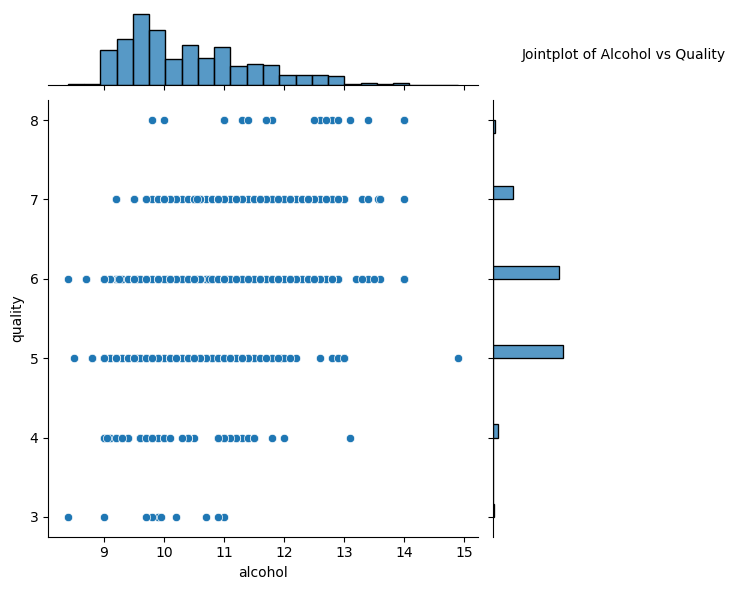

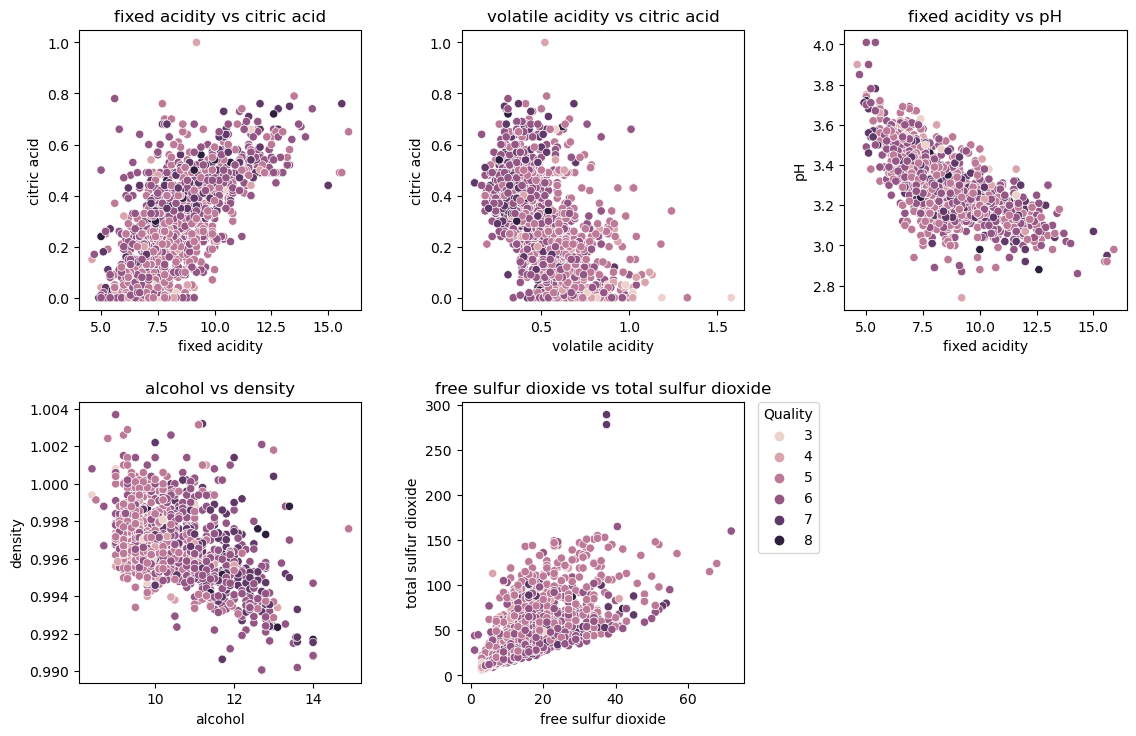

In [7]:
# Histogramas
plt.figure(figsize=(8, 6))
for i, col in enumerate(df.columns[:-1]):
    plt.subplot(3, 4, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

# Correlação de Pearson
pvalue_matrix = calculate_pvalues(df)
legend_pvalues = {col: pvalue_matrix.loc['quality', col] for col in pvalue_matrix.columns if col != 'qualidade'}

plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(method='pearson'), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Pearson')
plt.figtext(0.90, 0.85, 'p-Value vs. Quality', ha='left', va='center')
for i, (col, pval) in enumerate(legend_pvalues.items()):
    if col != 'quality':
        plt.figtext(0.90, 0.85 - 0.05*(i+1), f"{col}: {pval}", ha='left', va='center')
plt.show()

# Boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.title('Boxplot of Red Wine Dataset')
plt.show()

# Jointplot
plt.figure(figsize=(12, 8))
sns.jointplot(x='alcohol', y='quality', data=df, kind='scatter')
plt.figtext(0.9, 0.9, 'Jointplot of Alcohol vs Quality', ha='left', va='center')
plt.show()

duplas = [('fixed acidity', 'citric acid'), ('volatile acidity','citric acid'),('fixed acidity','pH'),('alcohol','density'),('free sulfur dioxide','total sulfur dioxide')]
plt.figure(figsize=(12, 8))
i = 0
for dupla in duplas:
    plt.subplot(2, 3, i+1) 
    scatter = sns.scatterplot(x=dupla[0], y=dupla[1], hue='quality', data=df)
    plt.title(f'{dupla[0]} vs {dupla[1]}')
    if i == len(duplas) - 1:  # Adicionar a legenda apenas uma vez no último gráfico.
        handles, labels = scatter.get_legend_handles_labels()
        plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    else:
        scatter.legend_.remove()
    i += 1

# Ajuste o espaçamento entre os gráficos
plt.tight_layout(pad=3.0, h_pad=2.0, w_pad=2.0)

# Adicionar a legenda global fora do loop
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Quality')
plt.show()

In [8]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
df_no_outliers = df.copy()
for column in df.drop('quality', axis=1).columns:
    df_no_outliers = remove_outliers_iqr(df_no_outliers, column)

In [19]:
#Modelos
def modelagem(x, y,grupo): #Aqui condensei alguns modelos para nao precisar repetir o código em cada alteração no dataset
    models = [DecisionTreeRegressor(), DecisionTreeClassifier(), ExtraTreesClassifier(), ]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

    accs = []
    for model in models:
        model.fit(x_train, y_train)
        predict = model.predict(x_test)
        acc = accuracy_score(y_test, predict)     
        print(f'{str(model)[:-2]} acc: { acc}')
        precision = [ precision_score(y_test, predict, average='micro'), precision_score(y_test, predict, average='macro', zero_division=1), precision_score(y_test, predict, average='weighted', zero_division=1)]
        recall = [ recall_score(y_test, predict, average='micro'), recall_score(y_test, predict, average='macro', zero_division=1), recall_score(y_test, predict, average='weighted', zero_division=1)]
        f1 = [ f1_score(y_test, predict, average='micro'), f1_score(y_test, predict, average='macro', zero_division=1), f1_score(y_test, predict, average='weighted', zero_division=1) ]
              
        accs.append([grupo, str(model)[:-2],  acc] + precision+recall +f1)
    return accs
#LogisticRegression precisa scalar x
def logistic(x, y, grupo):
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x)
    x_train,x_test,y_train,y_test = train_test_split(x_scaled,y,test_size = 0.2,random_state = 10)
    regressor = LogisticRegression(max_iter=1000)
    regressor.fit(x_train,y_train)
    predict = regressor.predict(x_test)
    precision = [ precision_score(y_test, predict, average='micro') , precision_score(y_test, predict, average='macro', zero_division=1) , precision_score(y_test, predict, average='weighted', zero_division=1) ]
    recall = [ recall_score(y_test, predict, average='micro') , recall_score(y_test, predict, average='macro', zero_division=1) , recall_score(y_test, predict, average='weighted', zero_division=1) ]
    f1 = [ f1_score(y_test, predict, average='micro') , f1_score(y_test, predict, average='macro', zero_division=1) , f1_score(y_test, predict, average='weighted', zero_division=1) ]
    return [[grupo, 'LogisticRegression',  accuracy_score(y_test,predict) ] + precision+ recall+ f1]

In [20]:
#Sem outliers
print('Dados sem outliers')
x = df_no_outliers.drop('quality', axis=1)
y = df_no_outliers['quality']
acc_sout = modelagem(x, y, 'Sem Outliers') + logistic(x, y, 'Sem Outliers')


Dados sem outliers
DecisionTreeRegressor acc: 0.7004405286343612
DecisionTreeClassifier acc: 0.6211453744493393
ExtraTreesClassifier acc: 0.7180616740088106


In [21]:
print('Dados padrão')
x = df.drop('quality', axis=1)
y = df['quality']
acc_padrao = modelagem(x, y, 'Padrão' ) + logistic(x, y, 'Padrão')

Dados padrão
DecisionTreeRegressor acc: 0.590625
DecisionTreeClassifier acc: 0.61875
ExtraTreesClassifier acc: 0.671875


In [22]:
#Agrupamento 1 (De 2 em 2)
df_a1 = df.copy()
df_a1['quality'] = df_a1['quality'].apply(lambda x: 0 if x < 3 else (1 if x < 5 else (2 if x < 7 else 3)))
x = df_a1.drop('quality', axis=1)
y = df_a1['quality']
acc_a1 = modelagem(x, y, 'A1') + logistic(x, y, 'A1')


DecisionTreeRegressor acc: 0.790625
DecisionTreeClassifier acc: 0.775
ExtraTreesClassifier acc: 0.859375


In [23]:
#Agrupamento 2 (>=7 ou <7)
df_a2 = df.copy()
df_a2['quality'] = df_a2['quality'].apply(lambda x: 0 if x < 7 else 1)
x = df_a2.drop('quality', axis=1)
y = df_a2['quality']
acc_a2= modelagem(x, y, 'A2') + logistic(x, y, 'A2')

DecisionTreeRegressor acc: 0.85
DecisionTreeClassifier acc: 0.865625
ExtraTreesClassifier acc: 0.890625


In [24]:
#VIF
x_cut = [100, 100]
while x_cut[1] >= 10:
    VIF = pd.DataFrame()
    VIF["Features"] = x.columns
    VIF["VIF"] = [variance_inflation_factor(x.values,i) for i in range(x.shape[1])]
    VIF = VIF.sort_values(by="VIF",ascending=False)
    x_cut = VIF.iloc[0]
    if x_cut[1] >= 10:
        x = x.drop(x_cut[0], axis=1)
        print(f'Removido a [coluna, VIF]: {[x_cut[0], x_cut[1]]}')
acc_vif = modelagem(x,y,'VIF') + logistic(x,y,'VIF')

Removido a [coluna, VIF]: ['density', 1479.2872086341736]
Removido a [coluna, VIF]: ['pH', 158.02573437108694]
Removido a [coluna, VIF]: ['fixed acidity', 37.55780900909876]
Removido a [coluna, VIF]: ['alcohol', 31.9152458421486]
Removido a [coluna, VIF]: ['sulphates', 12.942897035314433]
DecisionTreeRegressor acc: 0.8375
DecisionTreeClassifier acc: 0.834375
ExtraTreesClassifier acc: 0.89375


In [33]:
accs = acc_a1 + acc_a2 + acc_sout + acc_padrao + acc_vif
accs = pd.DataFrame(accs, columns=['Grupo', 'Tipo de Aprendizado', 'Accuracy', 'Precision micro','Precision macro','Precision w', 'Recall micro','Recall macro','Recall w', 'F1 micro', 'F1 macro','F1 w'])
acc = accs.pivot(index='Grupo', columns='Tipo de Aprendizado', values='Accuracy').reset_index()
print('Accuracy Score por Tipo de Aprendizado\n')
print('''A1: Quality separado em grupos de 2
A2: Quality separados em 2 grupos (<7 e >= 7)''')
acc

Accuracy Score por Tipo de Aprendizado

A1: Quality separado em grupos de 2
A2: Quality separados em 2 grupos (<7 e >= 7)


Tipo de Aprendizado,Grupo,DecisionTreeClassifier,DecisionTreeRegressor,ExtraTreesClassifier,LogisticRegression
0,A1,0.775000,0.790625,0.859375,0.831250
1,A2,0.865625,0.850000,0.890625,0.868750
2,Padrão,0.618750,0.590625,0.671875,0.562500
3,Sem Outliers,0.621145,0.700441,0.718062,0.612335
4,VIF,0.834375,0.837500,0.893750,0.837500


In [36]:
accs = accs.set_index(['Tipo de Aprendizado', 'Grupo']).sort_index().applymap(lambda x: 100*x).round(2)

In [38]:
accs

Accuracy  Precision micro  \
Tipo de Aprendizado    Grupo                                     
DecisionTreeClassifier A1               77.50            77.50   
                       A2               86.56            86.56   
                       Padrão           61.88            61.88   
                       Sem Outliers     62.11            62.11   
                       VIF              83.44            83.44   
DecisionTreeRegressor  A1               79.06            79.06   
                       A2               85.00            85.00   
                       Padrão           59.06            59.06   
                       Sem Outliers     70.04            70.04   
                       VIF              83.75            83.75   
ExtraTreesClassifier   A1               85.94            85.94   
                       A2               89.06            89.06   
                       Padrão           67.19            67.19   
                       Sem Outliers     71.81            71.81   
                       VIF              89.38            89.38   
LogisticRegression     A1               83.12            83.12   
                       A2               86.88            86.88   
                       Padrão           56.25            56.25   
                       Sem Outliers     61.23            61.23   
                       VIF              83.75            83.75   

                                     Precision macro  Precision w  \
Tipo de Aprendizado    Grupo                                        
DecisionTreeClassifier A1                      49.99        79.20   
                       A2                      74.53        86.67   
                       Padrão                  34.37        61.33   
                       Sem Outliers            42.68        63.12   
                       VIF                     68.90        83.85   
DecisionTreeRegressor  A1                      47.77        79.86   
                       A2                      71.67        85.25   
                       Padrão                  28.86        58.46   
                       Sem Outliers            37.96        72.57   
                       VIF                     70.13        85.11   
ExtraTreesClassifier   A1                      72.47        84.47   
                       A2                      84.92        88.29   
                       Padrão                  50.44        65.10   
                       Sem Outliers            82.04        73.74   
                       VIF                     89.67        89.44   
LogisticRegression     A1                      50.47        79.01   
                       A2                      77.59        85.10   
                       Padrão                  43.75        55.30   
                       Sem Outliers            75.14        63.96   
                       VIF                     42.14        71.11   

                                     Recall micro  Recall macro  Recall w  \
Tipo de Aprendizado    Grupo                                                
DecisionTreeClassifier A1                   77.50         51.17     77.50   
                       A2                   86.56         74.93     86.56   
                       Padrão               61.88         32.74     61.88   
                       Sem Outliers         62.11         59.09     62.11   
                       VIF                  83.44         69.81     83.44   
DecisionTreeRegressor  A1                   79.06         46.55     79.06   
                       A2                   85.00         72.37     85.00   
                       Padrão               59.06         30.73     59.06   
                       Sem Outliers         70.04         67.69     70.04   
                       VIF                  83.75         73.26     83.75   
ExtraTreesClassifier   A1                   85.94         49.59     85.94   
                       A2                   89.06         69.07 